In [40]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [41]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [42]:
def convert_arrays_back(data):
    """Recursively convert lists back to numpy arrays where appropriate"""
    if isinstance(data, dict):
        result = {}
        for key, value in data.items():
            if key in ['pipeline', 'depth-pro', 'gt'] and isinstance(value, list) and len(value) == 3:
                # Convert 3-element lists back to numpy arrays (normal vectors)
                result[key] = np.array(value)
            else:
                result[key] = convert_arrays_back(value)
        return result
    elif isinstance(data, list):
        return [convert_arrays_back(item) for item in data]
    else:
        return data

# Load the data
with open(os.path.join(project_root, 'assets', 'colmap', 'comparisons.json'), 'r') as f:
    loaded_data = json.load(f)

# Extract the three dictionaries and convert arrays back
f_comp = convert_arrays_back(loaded_data['f_comp'])
d_comp = convert_arrays_back(loaded_data['d_comp'])
n_comp = convert_arrays_back(loaded_data['n_comp'])

In [43]:
def compare_results_hybrid_filtering(
    f_comp: dict,
    d_comp: dict,
    n_comp: dict,
    percentile_threshold=95,
    absolute_thresholds=None,
    verbose=False
):
    """
    Hybrid filtering: statistical + absolute thresholds
    
    Args:
        percentile_threshold: Remove samples above this percentile (e.g., 95)
        absolute_thresholds: Dict with absolute limits {'f': 500, 'd': 300, 'n': 60}
    """
    if absolute_thresholds is None:
        absolute_thresholds = {'f': 500, 'd': 500, 'n': 60}  # Conservative limits
    
    # First pass: collect all errors
    all_data = []
    for image_name in f_comp.keys():
        # Calculate all errors (same as before)
        f_gt = f_comp[image_name]['gt']
        f_err_pp = abs(f_comp[image_name]['pipeline'] - f_gt) / f_gt * 100
        f_err_dp = abs(f_comp[image_name]['depth-pro'] - f_gt) / f_gt * 100

        d_gt = d_comp[image_name]['gt']
        d_err_pp = abs(d_comp[image_name]['pipeline'] - d_gt) / d_gt * 100
        d_err_dp = abs(d_comp[image_name]['depth-pro'] - d_gt) / d_gt * 100

        n_gt = n_comp[image_name]['gt']
        n_pp = n_comp[image_name]['pipeline']
        n_dp = n_comp[image_name]['depth-pro']
        angle_pp = np.degrees(np.arccos(np.clip(np.abs(np.dot(n_gt, n_pp)), 0.0, 1.0)))
        angle_dp = np.degrees(np.arccos(np.clip(np.abs(np.dot(n_gt, n_dp)), 0.0, 1.0)))
        
        all_data.append({
            'name': image_name,
            'f_pp': f_err_pp, 'f_dp': f_err_dp,
            'd_pp': d_err_pp, 'd_dp': d_err_dp,
            'n_pp': angle_pp, 'n_dp': angle_dp
        })
    
    # Calculate percentile thresholds for each metric
    metrics = ['f_pp', 'f_dp', 'd_pp', 'd_dp', 'n_pp', 'n_dp']
    thresholds = {}
    for metric in metrics:
        values = [row[metric] for row in all_data]
        thresholds[metric] = np.percentile(values, percentile_threshold)
    
    # Second pass: filter data
    filtered_data = []
    excluded = []
    
    for row in all_data:
        exclude = False
        reasons = []
        
        # Check absolute thresholds
        if (row['f_pp'] > absolute_thresholds['f'] or row['f_dp'] > absolute_thresholds['f']):
            exclude = True
            reasons.append("focal")
        if (row['d_pp'] > absolute_thresholds['d'] or row['d_dp'] > absolute_thresholds['d']):
            exclude = True
            reasons.append("distance")
        if (row['n_pp'] > absolute_thresholds['n'] or row['n_dp'] > absolute_thresholds['n']):
            exclude = True
            reasons.append("normal")
            
        # Check percentile thresholds
        for metric in metrics:
            if row[metric] > thresholds[metric]:
                exclude = True
                reasons.append(f"{metric}_percentile")
                break
        
        if exclude:
            excluded.append((row['name'], reasons))
        else:
            filtered_data.append(row)
    
    if verbose:
        print(f"Excluded {len(excluded)} samples, kept {len(filtered_data)}")
        for name, reasons in excluded:
            print(f"  {name}: {', '.join(reasons)}")
    
    # Extract filtered results
    return {
        'f_errors_pipeline': [row['f_pp'] for row in filtered_data],
        'f_errors_depthpro': [row['f_dp'] for row in filtered_data],
        'd_errors_pipeline': [row['d_pp'] for row in filtered_data],
        'd_errors_depthpro': [row['d_dp'] for row in filtered_data],
        'n_errors_pipeline': [row['n_pp'] for row in filtered_data],
        'n_errors_depthpro': [row['n_dp'] for row in filtered_data],
        'kept_samples': [row['name'] for row in filtered_data]
    }

In [44]:
def plot_error_distributions(results, save_path=None):
    """Plot histograms of error distributions"""
    f_errors_pipeline = results['f_errors_pipeline']
    f_errors_depthpro = results['f_errors_depthpro']
    d_errors_pipeline = results['d_errors_pipeline']
    d_errors_depthpro = results['d_errors_depthpro']
    n_errors_pipeline = results['n_errors_pipeline']
    n_errors_depthpro = results['n_errors_depthpro']

    plt.figure(figsize=(15, 5))
    
    # Focal Length Errors
    plt.subplot(1, 3, 1)
    plt.hist(f_errors_pipeline, bins=20, alpha=0.7, label='Pipeline', color='skyblue', edgecolor='black')
    plt.hist(f_errors_depthpro, bins=20, alpha=0.7, label='DepthPro', color='lightcoral', edgecolor='black')
    plt.title('Focal Length Errors Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Error (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Distance Errors
    plt.subplot(1, 3, 2)
    plt.hist(d_errors_pipeline, bins=20, alpha=0.7, label='Pipeline', color='skyblue', edgecolor='black')
    plt.hist(d_errors_depthpro, bins=20, alpha=0.7, label='DepthPro', color='lightcoral', edgecolor='black')
    plt.title('Distance Errors Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Error (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Normal Errors
    plt.subplot(1, 3, 3)
    plt.hist(n_errors_pipeline, bins=20, alpha=0.7, label='Pipeline', color='skyblue', edgecolor='black')
    plt.hist(n_errors_depthpro, bins=20, alpha=0.7, label='DepthPro', color='lightcoral', edgecolor='black')
    plt.title('Normal Errors Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Error (degrees)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_box_plots(results, save_path=None):
    """Plot box plots for comparison"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Focal Length Errors
    axes[0].boxplot([results['f_errors_pipeline'], results['f_errors_depthpro']], 
                    tick_labels=['Pipeline', 'DepthPro'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[0].set_title('Focal Length Errors', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Error (%)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Distance Errors
    axes[1].boxplot([results['d_errors_pipeline'], results['d_errors_depthpro']], 
                    tick_labels=['Pipeline', 'DepthPro'], patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[1].set_title('Distance Errors', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Error (%)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Normal Errors
    axes[2].boxplot([results['n_errors_pipeline'], results['n_errors_depthpro']], 
                    tick_labels=['Pipeline', 'DepthPro'], patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[2].set_title('Normal Errors', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Error (degrees)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_scatter_comparison(results, save_path=None):
    """Plot scatter plots comparing pipeline vs depthpro"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Focal Length
    axes[0].scatter(results['f_errors_pipeline'], results['f_errors_depthpro'], 
                   alpha=0.6, color='blue', s=50)
    max_f = max(max(results['f_errors_pipeline']), max(results['f_errors_depthpro']))
    axes[0].plot([0, max_f], [0, max_f], 'r--', alpha=0.8, linewidth=2)
    axes[0].set_xlabel('Pipeline Error (%)', fontsize=12)
    axes[0].set_ylabel('DepthPro Error (%)', fontsize=12)
    axes[0].set_title('Focal Length: Pipeline vs DepthPro', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Distance
    axes[1].scatter(results['d_errors_pipeline'], results['d_errors_depthpro'], 
                   alpha=0.6, color='green', s=50)
    max_d = max(max(results['d_errors_pipeline']), max(results['d_errors_depthpro']))
    axes[1].plot([0, max_d], [0, max_d], 'r--', alpha=0.8, linewidth=2)
    axes[1].set_xlabel('Pipeline Error (%)', fontsize=12)
    axes[1].set_ylabel('DepthPro Error (%)', fontsize=12)
    axes[1].set_title('Distance: Pipeline vs DepthPro', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Normal
    axes[2].scatter(results['n_errors_pipeline'], results['n_errors_depthpro'], 
                   alpha=0.6, color='red', s=50)
    max_n = max(max(results['n_errors_pipeline']), max(results['n_errors_depthpro']))
    axes[2].plot([0, max_n], [0, max_n], 'r--', alpha=0.8, linewidth=2)
    axes[2].set_xlabel('Pipeline Error (degrees)', fontsize=12)
    axes[2].set_ylabel('DepthPro Error (degrees)', fontsize=12)
    axes[2].set_title('Normal: Pipeline vs DepthPro', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_summary_statistics(results):
    """Print and plot summary statistics"""
    metrics = {
        'Focal Length (%)': {
            'Pipeline': results['f_errors_pipeline'],
            'DepthPro': results['f_errors_depthpro']
        },
        'Distance (%)': {
            'Pipeline': results['d_errors_pipeline'],
            'DepthPro': results['d_errors_depthpro']
        },
        'Normal (degrees)': {
            'Pipeline': results['n_errors_pipeline'],
            'DepthPro': results['n_errors_depthpro']
        }
    }
    
    print("Summary Statistics:")
    print("="*60)
    
    for metric_name, methods in metrics.items():
        print(f"\n{metric_name}:")
        print("-" * len(metric_name))
        
        for method_name, errors in methods.items():
            mean_err = np.mean(errors)
            median_err = np.median(errors)
            std_err = np.std(errors)
            min_err = np.min(errors)
            max_err = np.max(errors)
            
            print(f"{method_name:>10}: Mean={mean_err:6.2f}, Median={median_err:6.2f}, "
                  f"Std={std_err:6.2f}, Min={min_err:6.2f}, Max={max_err:6.2f}")

In [45]:
results = compare_results_hybrid_filtering(
    f_comp, d_comp, n_comp,
    percentile_threshold=80,
    absolute_thresholds={'f': 300, 'd': 200, 'n': 45}
)

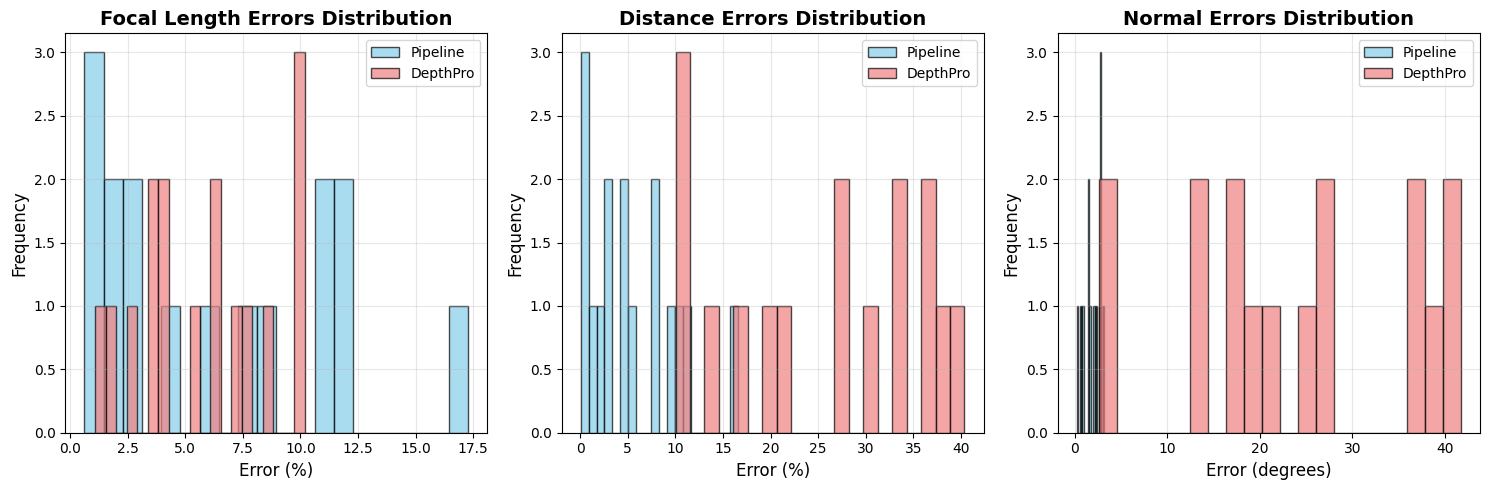

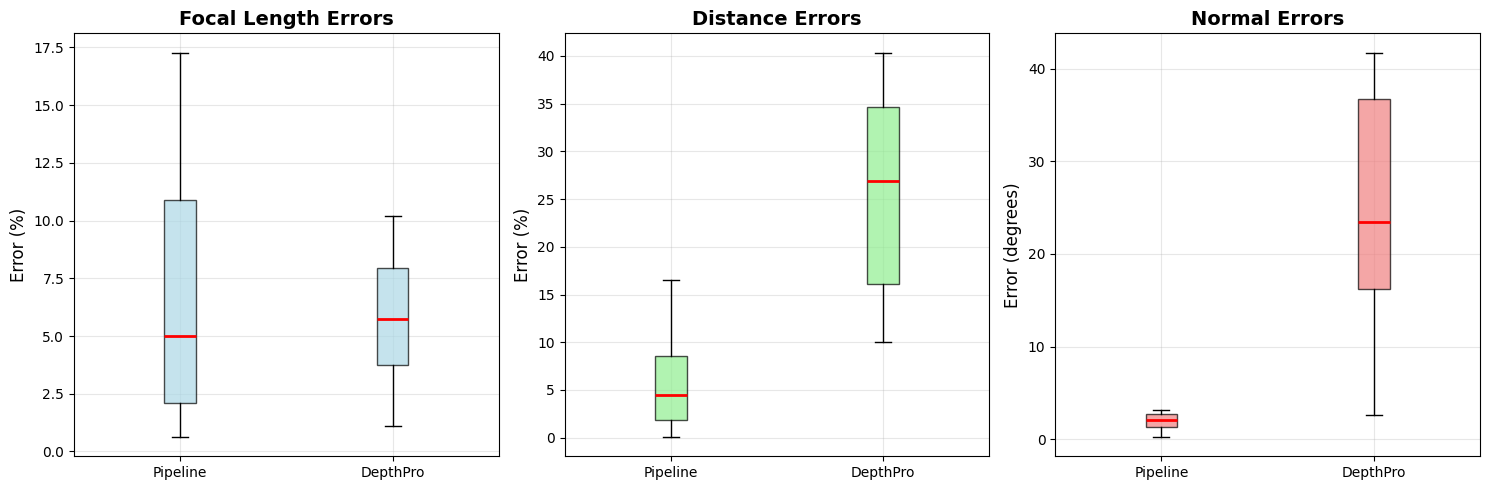

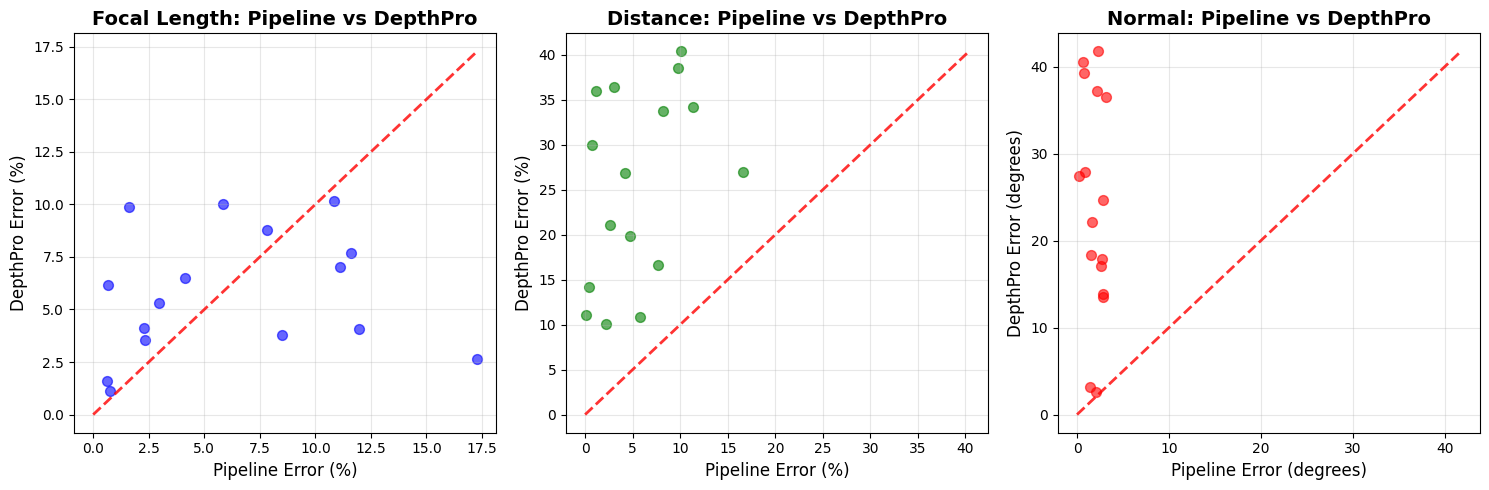

Summary Statistics:

Focal Length (%):
----------------
  Pipeline: Mean=  6.26, Median=  4.99, Std=  4.98, Min=  0.62, Max= 17.28
  DepthPro: Mean=  5.78, Median=  5.74, Std=  2.88, Min=  1.10, Max= 10.18

Distance (%):
------------
  Pipeline: Mean=  5.53, Median=  4.46, Std=  4.56, Min=  0.06, Max= 16.56
  DepthPro: Mean= 25.42, Median= 26.93, Std= 10.33, Min= 10.01, Max= 40.36

Normal (degrees):
----------------
  Pipeline: Mean=  1.92, Median=  2.11, Std=  0.89, Min=  0.24, Max=  3.15
  DepthPro: Mean= 23.99, Median= 23.41, Std= 12.24, Min=  2.62, Max= 41.73


In [46]:
plot_error_distributions(results)
plot_box_plots(results)
plot_scatter_comparison(results)
plot_summary_statistics(results)

In [47]:
# Print number of samples kept
print(f"\nNumber of samples kept after filtering: {len(results['kept_samples'])}")


Number of samples kept after filtering: 16


In [48]:
def save_box_plot(results, save_path=None):
    """Save box plot for focal length errors"""
    plt.figure(figsize=(6, 3))
    
    # Focal Length Errors
    plt.boxplot([results['f_errors_pipeline'], results['f_errors_depthpro']], 
                tick_labels=['Pipeline', 'DepthPro'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Focal Length Errors', fontsize=16, fontweight='bold')
    plt.ylabel('Error (%)', fontsize=14)
    plt.tick_params(axis='x', labelsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

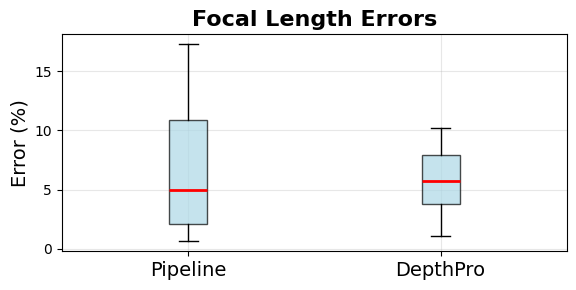

In [49]:
save_box_plot(results, save_path=os.path.join(project_root, 'focal_length_boxplot.png'))

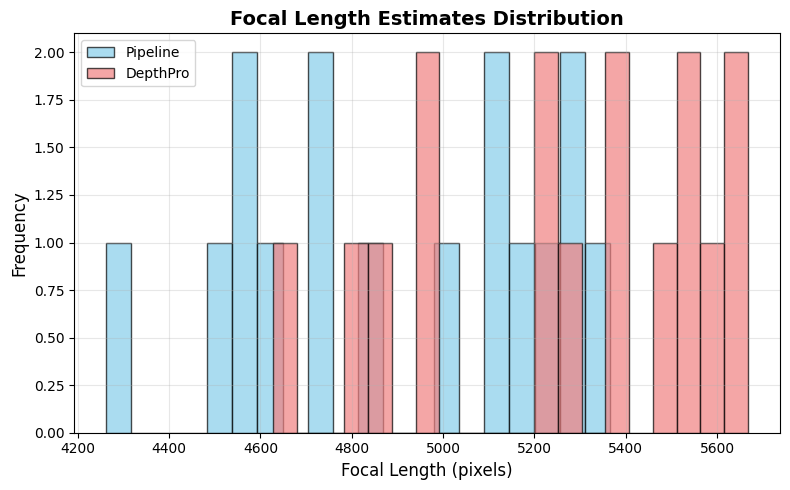

In [50]:
# Plot the distribution of focal length estimations
f_estimates_pipeline = [f_comp[name]['pipeline'] for name in results['kept_samples']]
f_estimates_depthpro = [f_comp[name]['depth-pro'] for name in results['kept_samples']]

plt.figure(figsize=(8, 5))
plt.hist(f_estimates_pipeline, bins=20, alpha=0.7, label='Pipeline', color='skyblue', edgecolor='black')
plt.hist(f_estimates_depthpro, bins=20, alpha=0.7, label='DepthPro', color='lightcoral', edgecolor='black')
plt.title('Focal Length Estimates Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Focal Length (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

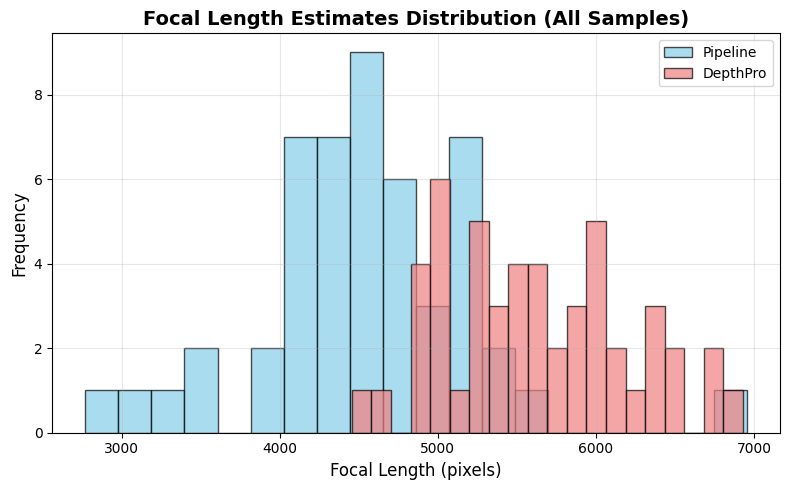

In [51]:
# Plot the distribution of focal length estimations (using all samples, no filtering)
f_estimates_pipeline_all = [f_comp[name]['pipeline'] for name in f_comp.keys()]
f_estimates_depthpro_all = [f_comp[name]['depth-pro'] for name in f_comp.keys()]

plt.figure(figsize=(8, 5))
plt.hist(f_estimates_pipeline_all, bins=20, alpha=0.7, label='Pipeline', color='skyblue', edgecolor='black')
plt.hist(f_estimates_depthpro_all, bins=20, alpha=0.7, label='DepthPro', color='lightcoral', edgecolor='black')
plt.title('Focal Length Estimates Distribution (All Samples)', fontsize=14, fontweight='bold')
plt.xlabel('Focal Length (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Print mean and std of focal length estimates
mean_f_pipeline = np.mean(f_estimates_pipeline_all)
std_f_pipeline = np.std(f_estimates_pipeline_all)
mean_f_depthpro = np.mean(f_estimates_depthpro_all)
std_f_depthpro = np.std(f_estimates_depthpro_all)

print(f"Pipeline Focal Length: Mean = {mean_f_pipeline:.2f} px, Std = {std_f_pipeline:.2f} px")
print(f"DepthPro Focal Length: Mean = {mean_f_depthpro:.2f} px, Std = {std_f_depthpro:.2f} px")

Pipeline Focal Length: Mean = 4543.81 px, Std = 685.29 px
DepthPro Focal Length: Mean = 5617.39 px, Std = 588.74 px
